<a href="https://colab.research.google.com/github/aashu-0/Food101/blob/main/Food101_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## EffnetB2 model: Food101 Dataset

### Setup

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms


# installing torchmetrics and torchinfo
try:
  from torchmetrics import Accuracy
  from torchinfo import summary
except:
  print(f'[INFO] Installing torchmetrics and torchinfo')
  !pip install torchmetrics
  !pip install torchinfo

In [ ]:
# custom functions import from github

try:
  from modualr_pytorch import data_setup, engine
except:
  print(f'[INFO] installing required scripts from github')
  !git clone https://github.com/aashu-0/learn-pytorch
  !mv learn-pytorch/modualr_pytorch .
  !rm -rf learn-pytorch
  from modualr_pytorch import data_setup, engine

[INFO] installing required scripts from github
Cloning into 'learn-pytorch'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 119 (delta 43), reused 5 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (119/119), 49.04 MiB | 22.48 MiB/s, done.
Resolving deltas: 100% (43/43), done.


### Creating a EffNetB2 model extractor

In [ ]:
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2_transforms = weights.transforms()
model = torchvision.models.efficientnet_b2(weights=weights)

model.classifier

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 83.8MB/s]


Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [ ]:
def create_effnetb2_model(num_classes: int,
                          seed: int=42):

  # get pretrained weights
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

  #effnetb2 transforms
  effnetb2_transforms = weights.transforms()

  # effnet model
  model = torchvision.models.efficientnet_b2(weights=weights)

  # freeze all the base layers
  for parm in model.parameters():
    parm.requires_grad = False

  # change classifier head
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408,
                out_features= num_classes)
  )

  return model, effnetb2_transforms

In [ ]:
# model and transforms instance

effnetb2_model, effnetb2_transforms = create_effnetb2_model(
    num_classes=101,
    seed=42
)

In [ ]:
from torchinfo import summary

summary(model=effnetb2_model,
        input_size=(1,3,224,224),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### Apply `.TrivialAugmentWide()` data augmentation to training images

In [ ]:
effnetb2_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms
])

effnetb2_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

### Downloading the complete data using `torchvision.datasets.Food101`

In [ ]:
from torchvision import datasets

# create a data folder
from pathlib import Path
data_dir = Path('data')

# get the complete data
train_data = datasets.Food101(root=data_dir,
                              split='train',
                              transform= effnetb2_train_transforms,
                              download=True)

test_data=datasets.Food101(root=data_dir,
                           split='test',
                           transform = effnetb2_transforms,
                           download=True)

100%|██████████| 5.00G/5.00G [03:12<00:00, 26.0MB/s] 


Extracting data/food-101.tar.gz to data


In [ ]:
# get class names
food101_class_names = train_data.classes

food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### Turn dataset into dataloader

In [ ]:
import os
import torch

BATCH_SIZE =32
NUM_WORKERS = os.cpu_count()

# training dataloader
food101_train_dataloader = torch.utils.data.DataLoader(train_data,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               num_workers = NUM_WORKERS)

# test dataloader
food101_test_dataloader = torch.utils.data.DataLoader(test_data,
                                              batch_size = BATCH_SIZE,
                                              shuffle = False,
                                              num_workers=NUM_WORKERS)


In [ ]:
# device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
from modualr_pytorch import engine

# optimizer
optimizer = torch.optim.Adam(params=effnetb2_model.parameters(),
                             lr=0.001)

# loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
# label smoothing for better generaliation and preventing overfitting

# accuracy fn
acc_fn= Accuracy(task= 'multiclass', num_classes=len(food101_class_names)).to(device)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

effnetb2_food101_results = engine.train(model= effnetb2_model,
                                        train_dataloader= food101_train_dataloader,
                                        test_dataloader=food101_test_dataloader,
                                        optimizer = optimizer,
                                        loss_fn= loss_fn,
                                        accuracy_fn= acc_fn,
                                        epochs=5,
                                        device = device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 2.9786 | Train acc: 0.4083 | Test Loss: 2.1807 | Test acc: 0.6112
Epoch: 1 | Train Loss: 2.6478 | Train acc: 0.4819 | Test Loss: 2.1121 | Test acc: 0.6254
Epoch: 2 | Train Loss: 2.6167 | Train acc: 0.4914 | Test Loss: 2.0740 | Test acc: 0.6391
Epoch: 3 | Train Loss: 2.5926 | Train acc: 0.4986 | Test Loss: 2.0576 | Test acc: 0.6409
Epoch: 4 | Train Loss: 2.5946 | Train acc: 0.4973 | Test Loss: 2.0573 | Test acc: 0.6447


well it takes around 42 minutes to train the model !!

### Loss Curves

In [ ]:
# a function called plot_loss_curve to plot one for our model

from typing import Tuple, Dict, List
def plot_loss_curve(results: Dict[str, List[float]]):
  # loss values
  train_loss = results['train_loss']
  test_loss = results['test_loss']

  # accuracy values
  # move tensors to the CPU before converting to numpy
  train_accuracy = [tensor.cpu() for tensor in results['train_acc']]
  test_accuracy = [tensor.cpu() for tensor in results['test_acc']]

  # epochs as list
  epochs = range(len(results['train_loss']))

  plt.figure(figsize=(15,7))

  # plot loss
  plt.subplot(1,2,1)
  plt.plot(epochs, train_loss, label ='train_loss')
  plt.plot(epochs, test_loss, label ='test_loss')
  plt.xlabel("Epochs")
  plt.ylabel('Loss')
  plt.title('Loss Curves')
  plt.legend()

  # plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, train_accuracy, label ='train_accuracy')
  plt.plot(epochs, test_accuracy, label ='test_accuracy')
  plt.xlabel("Epochs")
  plt.ylabel('Accuracy')
  plt.title('Accuracy Curves')
  plt.legend()

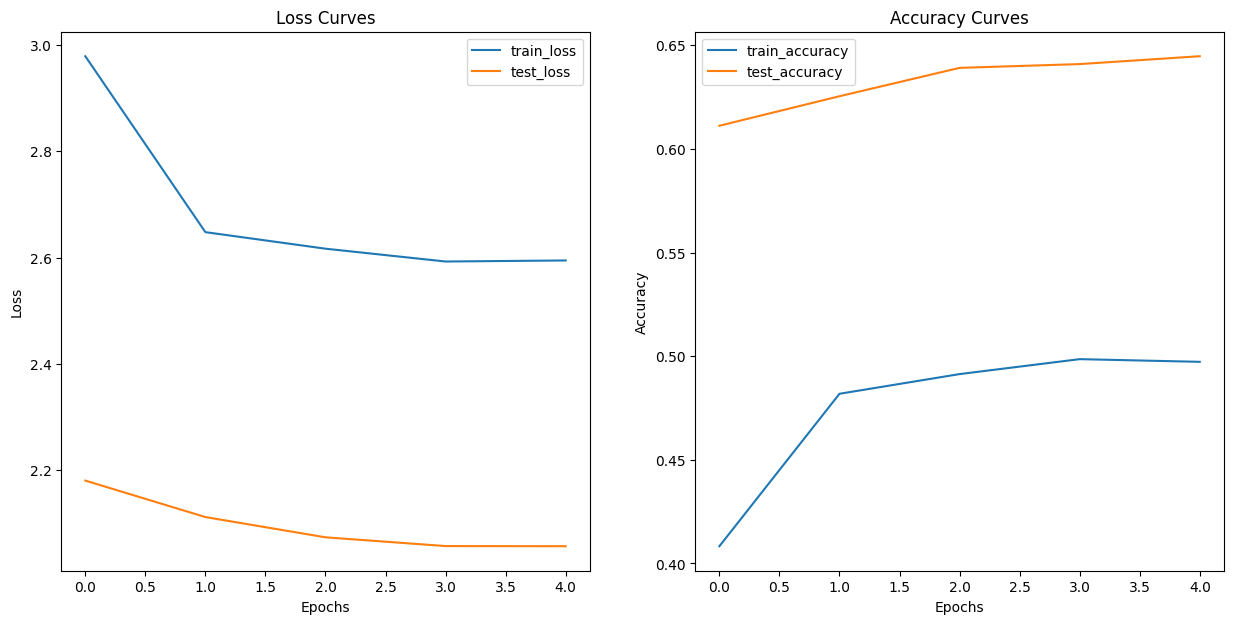

In [ ]:
plot_loss_curve(effnetb2_food101_results )

### saving our model

In [ ]:
from modualr_pytorch import utils

utils.save_model(model=effnetb2_model,
                 target_dir='models',
                 model_name = 'effnetb2_food101_model.pth')

Saving model to: models/effnetb2_food101_model.pth


### loading our model back, just to check out

In [ ]:
# create model instance

loaded_effnetb2_model, effnetb2_transforms = create_effnetb2_model(
    num_classes = 101,
    seed=42
)

# loading the saved model dict
loaded_effnetb2_model.load_state_dict(torch.load("models/effnetb2_food101_model.pth",weights_only=True))

<All keys matched successfully>

In [ ]:
# checking the model size

from pathlib import Path

effnetb2_food101_model_size = Path('models/effnetb2_food101_model.pth').stat().st_size // (1024*1024)
print(f'EffNetB2 Model Size: {effnetb2_food101_model_size} MB')

EffNetB2 Model Size: 30 MB


In [ ]:
# number of parameters

effnetb2_food101_params = sum(torch.numel(param) for param in effnetb2_model.parameters())
print(f'Number of parameters in Food101 EffNetB2 model: {effnetb2_food101_params}')

Number of parameters in Food101 EffNetB2 model: 7843303


### Turning Food101 into a deployable app
on hf spaces

our directory will look like
```
demos/
└── food101/
    ├── effnetb2_food101_model.pth
    ├── app.py
    ├── class_names.txt
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```

### Create a demo folder and example folder

In [ ]:
import shutil
from pathlib import Path

food101_demo_path = Path('demo/food101_model/')

# remove file if already exist
if food101_demo_path.exists():
    shutil.rmtree(food101_demo_path)


# make dir otherwise
food101_demo_path.mkdir(parents=True,
                        exist_ok = True)

# create examples directory
(food101_demo_path/ 'examples').mkdir(parents=True,
                                     exist_ok = True)

In [ ]:
# download
!wget https://raw.githubusercontent.com/aashu-0/images/refs/heads/main/IMG_20230924_214608.jpg

# move
!mv IMG_20230924_214608.jpg demo/food101_model/examples/my-first-pizza.jpg

# move trained model to food101 demo folder
! mv models/effnetb2_food101_model.pth demo/food101_model


--2025-01-30 18:04:01--  https://raw.githubusercontent.com/aashu-0/images/refs/heads/main/IMG_20230924_214608.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3940014 (3.8M) [image/jpeg]
Saving to: ‘IMG_20230924_214608.jpg’

IMG_20230924_214608 100%[===================>]   3.76M  --.-KB/s    in 0.07s   

2025-01-30 18:04:01 (53.5 MB/s) - ‘IMG_20230924_214608.jpg’ saved [3940014/3940014]



### Saving Food101 names to file `101_food_names.txt`

In [ ]:
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# create path for 101_food_names.txt

food101_class_names_path = food101_demo_path/ '101_food_names.txt'

# write food101 class names list to file
with open(food101_class_names_path, 'w') as f:
    print(f'[INFO] Saving Food11 class names to {food101_class_names_path}')
    f.write("\n".join(food101_class_names)) # new line after each class

[INFO] Saving Food11 class names to demo/food101_model/101_food_names.txt


In [ ]:
# open and read each line and convert into a list
with open(food101_class_names_path, 'r') as f:
    food101_class_names_read = [food.strip( ) for food in f.readlines()]

# view list
# len(food101_class_names_read)
food101_class_names[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

### Food101 model into `model.py`

In [ ]:
%%writefile demo/food101_model/model.py

import torch
import torchvision

from torch import nn

ef create_effnetb2_model(num_classes: int,
                          seed: int =42):

  #weights, transforms and model instance
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()

  model = torchvision.models.efficientnet_b2(weights= weights)

  # freeze all layers of base model
  for param in model.parameters():
    param.requires_grad = False  # i.e don't keep track of gradients

    # change classifier head
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features= num_classes)
    )

    return model,transforms

Writing demo/food101_model/model.py


### food101 gradio app into `app.py`

In [ ]:
%%writefile demo/food101_model/app.py

import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# class_names
with open('101_food_names.txt','r') as f:
    class_names = [food_names.strip( ) for food_name in f.readlines()]


#create effnet model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes = len(class_names),
    seed=42
)

# load saved weights
effnetb2.load_state_dict(torch.load(
    f = 'effnetb2_food101_model.pth',
    map_location=torch.device('cpu')
    )
)

# predict

def predict(img) -> Tuple[Dict, float]:

  # start timer
  start_timer = timer()

  # perform transform aadd batch dim
  img = effnetb2_transforms(img).unsqueeze(0)

  # modle on eval mode
  effnetb2.eval()
  with torch.inference_mode():

    # pass the img to the model and get pred prob
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # pred time
  pred_time = round(timer() - start_timer, 5)

  # return pred dict and pred time
  return pred_labels_and_probs, pred_time

# gradio app

title = "Food101 🍕🍪 "
description = "A computer vision model based on EffNetB2 model to clasify images of food into 101 classes. \n [Food101 Dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/)"
article = "Made with ❤️ [github](https://github.com/aashu-0)"

# create examples list
example_list = [['examples/' +example] for example in os.listdir('examples')]

# gradio demo
demo = gr.Interface(fn= predict,
                    inputs = gr.Image(type= 'pil'),
                    outputs= [gr.Label(num_top_classes=5, label='Predictions'),
                              gr.Number(label="Predictions time(in seconds)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article
                    )

# launch
demo.launch()


Writing demo/food101_model/app.py


In [ ]:
torch.__version__

'2.5.1+cu121'

In [ ]:
torchvision.__version__

'0.20.1+cu121'

In [ ]:
gr.__version__

'5.13.2'

In [ ]:
%%writefile demo/food101_model/requirements.txt
torch==2.5.1+cu121
torchvision==0.20.1+cu121
gradio==5.13.2

Writing demo/food101_model/requirements.txt


In [ ]:
# Zip foodvision_big folder but exclude certain files
!cd demo/food101_model && zip -r ../food101_model.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# download manually

updating: 101_food_names.txt (deflated 48%)
updating: app.py (deflated 53%)
updating: effnetb2_food101_model.pth (deflated 8%)
updating: examples/ (stored 0%)
updating: examples/my-first-pizza.jpg (deflated 0%)
updating: model.py (deflated 47%)
updating: requirements.txt (deflated 15%)
